In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from glob import glob

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter,white_signals,gp_signals,signal_base
from enterprise.signals.utils import powerlaw

from enterprise_extensions import blocks
from enterprise_extensions.model_utils import get_tspan

from la_forge.core import Core

import sys
sys.path.append('../')

from defiant import OptimalStatistic
from defiant import utils

In [2]:
datadir = enterprise.__path__[0] + '/datafiles/mdc_open1/'
parfiles = sorted(glob(datadir + '/*.par'))
timfiles = sorted(glob(datadir + '/*.tim'))

psrs = [Pulsar(par,tim) for par,tim in zip(parfiles,timfiles)]

inj_params = {'gw_log10_A':np.log10(5e-14)}

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [3]:
Tspan = get_tspan(psrs)

efac = parameter.Constant(1.0)
ef = white_signals.MeasurementNoise(efac=efac)

curn = blocks.common_red_noise_block(psd='powerlaw',Tspan=Tspan,components=10,
                                     gamma_val=13./3.,logmin=-18,logmax=-12,name='gw')

tm = gp_signals.MarginalizingTimingModel(use_svd=True)

model = tm + ef + curn

pta = signal_base.PTA([model(psr) for psr in psrs])

In [4]:
OS_obj = OptimalStatistic(psrs,pta=pta,gwb_name='gw',core_path='MDC1_FG_CURN_samples.core')

Loading data from HDF5 file....


In [5]:
OS_obj.set_orf(['hd','dipole','monopole'])
xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(params=inj_params,pair_covariance=True,narrowband=False)
fgw = OS_obj.freqs

100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


In [9]:
xi_range = np.linspace(0.01,np.pi,1000)
hd_mod = utils.orf_xi(xi_range,'hd')
inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)

In [24]:
problem_freq = 4
ORF = OS_obj.orf_design_matrix
data = rhok[problem_freq]
cov = Ck[problem_freq]

xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[problem_freq],
                                                     Ck[problem_freq],
                                                     bins=10,orf='hd')

/Users/gersbaka/Documents/Projects/defiant/notebooks/../defiant/utils.py:333: RuntimeWarning: invalid value encountered in sqrt
  sigavg[i] = np.abs(bin_orf)*np.sqrt(s2)


In [44]:
np.median(cov[0,0])

6.3689366064460605e-27

In [52]:
a2,a2s = utils.linear_solve(ORF,cov*1e30,data)
a2s = a2s/1e30

In [53]:
print(a2)
print(a2s)

[ 3.00386817e-13 -8.28768374e-16 -1.30508142e-13]
[[ 1.99993407e-27 -2.59519600e-29 -8.60365530e-28]
 [-2.59519600e-29  1.36611538e-29 -2.05502492e-30]
 [-8.60365530e-28 -2.05502491e-30  3.91517818e-28]]


In [54]:
a2/np.sqrt(np.diag(a2s))

array([ 6.71696414, -0.22422781, -6.59571438])

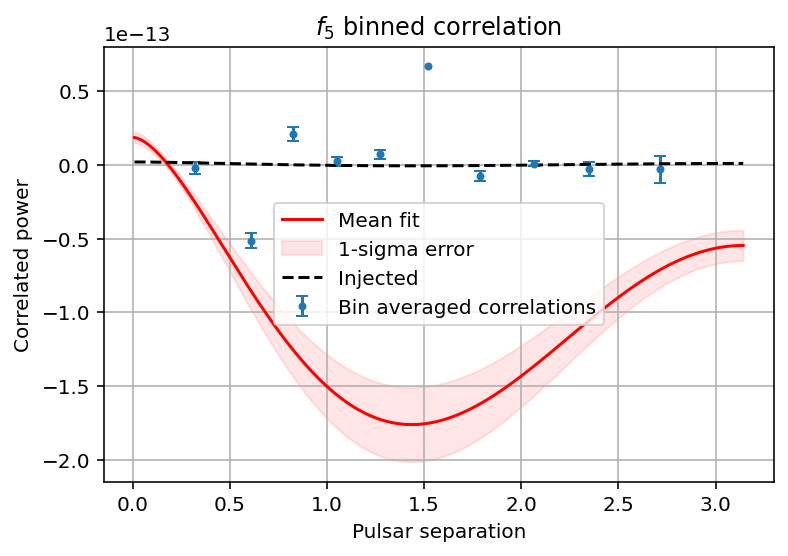

In [55]:
plt.title(f'$f_{problem_freq+1}$ binned correlation')

plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
#clipped = utils.clip_covariance(cov,1e-32)
mean,mean_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,a2,a2s,['hd','dipole','monopole'])
plt.plot(xi_range,mean,'-r',label='Mean fit')
plt.fill_between(xi_range,(mean-mean_sig), (mean+mean_sig),color='r',alpha=0.1,label='1-sigma error')

plt.plot(xi_range,inj_pl[problem_freq]*hd_mod,'--k',label='Injected')

plt.xlabel('Pulsar separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()

### A New way to fit

In [20]:
from scipy.linalg import cho_factor,cho_solve

cholesky = cho_factor(cov)
fisher = cho_factor( ORF.T @ cho_solve(cholesky,ORF) )

dirtymap = ORF.T @ cho_solve(cholesky,data)

print(cho_solve(fisher,dirtymap))

[ 4.04559019e-14 -2.33150598e-14 -1.75419069e-14]


In [ ]:
plt.title(f'$f_{problem_freq+1}$ binned correlation')

plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
#clipped = utils.clip_covariance(cov,1e-32)
mean,mean_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,a2,a2s,['hd','dipole','monopole'])
plt.plot(xi_range,mean,'-r',label='Mean fit')
plt.fill_between(xi_range,(mean-mean_sig), (mean+mean_sig),color='r',alpha=0.1,label='1-sigma error')

plt.plot(xi_range,inj_pl[problem_freq]*hd_mod,'--k',label='Injected')

plt.xlabel('Pulsar separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()